<a href="https://colab.research.google.com/github/gabrielfea/previsaoacoes/blob/main/analise_modelo_pred_acoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima
!pip install tensorflow
!pip install keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import metrics
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn import preprocessing

from pmdarima import auto_arima

import yfinance as yf
yf.pdr_override()

from pandas_datareader import data as pdr

import datetime
from datetime import date
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import plotly.figure_factory as ff
import plotly.offline as py
from plotly.subplots import make_subplots

from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten,TimeDistributed,RepeatVector
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Dropout

tf.random.set_seed(123)
np.random.seed(123)
import random
random.seed(123)

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


# Análise de Ação B3

In [ ]:
def get(tickers,startdate,enddate):
   def data(ticker):
       return(pdr.get_data_yahoo(ticker, start=startdate,end=enddate))
   datas = map(data,tickers)
   all_data = pd.concat(datas, keys=tickers, names=['Ticker', 'Date'])
   return all_data

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [ ]:
def preve_acao(asset,imprime_grafico=False):
  #asset = "ITUB4.SA"
  tickers = [asset]
  startdate = date(2000,1,1)
  enddate = date.today()

  data = get(tickers,startdate,enddate)


  #data.loc[asset].tail()

  df = data.loc[asset,["Close","High","Low"]]
  df_cycle,df_trend = hpfilter(df["Close"], lamb=1600)
  #df["Close"].plot(figsize=(15,6)).autoscale(axis='x',tight=True)
  #df_trend.plot(figsize=(15,6)).autoscale(axis='x',tight=True)
  df["Trend"] = df_trend
  df_close = df["Close"]
  tamanho = len(df["Close"])

  h = 90
  predition_X = df.tail(h)
  uni_data = df.drop(df.tail(h).index)

  x_scaler = preprocessing.StandardScaler()
  y_scaler = preprocessing.StandardScaler()
  dataX = x_scaler.fit_transform(df)
  dataY = y_scaler.fit_transform(df[['Trend']]) #y_scaler.fit_transform(np.array(df).reshape(-1, 1))

  hist_window = 60
  horizon = h

  index_prev = data.loc[asset].index[-h:]
  index_prev

  from pandas.tseries.holiday import USFederalHolidayCalendar
  from pandas.tseries.offsets import CustomBusinessDay
  us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
  index_prev_oficial = pd.period_range(start=index_prev[-1], periods=h+1, freq=us_bd)[1:]


  TRAIN_SPLIT = int((tamanho-h)*0.80)
  x_train_multi, y_train_multi = custom_ts_multi_data_prep(
      dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
  x_val_multi, y_val_multi= custom_ts_multi_data_prep(
      dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

  BATCH_SIZE = 60
  BUFFER_SIZE = 60

  train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
  train_data_multi = train_data_multi.cache().batch(BATCH_SIZE).repeat()

  val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
  val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

  LSTM_model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(60, input_shape=x_train_multi.shape[-2:],return_sequences=True),
      tf.keras.layers.LSTM(units=60,return_sequences=True),
      tf.keras.layers.LSTM(units=60),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(units=horizon),
  ])
  LSTM_model.compile(optimizer='adam', loss='mse')

  model_path = f'drive/MyDrive/modelos_ia_prev_acoes/{asset[:5]}.h5'

  try:
    Trained_model = tf.keras.models.load_model(model_path)
    #Trained_model.summary()
  except:
    print("Modelo não treinado ainda!")
    EVALUATION_INTERVAL = 100
    EPOCHS = 150
    history = LSTM_model.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_multi, validation_steps=50,verbose =1,callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])
    Trained_model = tf.keras.models.load_model(model_path)
    #Trained_model.summary()

  data_val = x_scaler.fit_transform(uni_data.tail(hist_window))
  val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
  Predicted_results = Trained_model.predict(val_rescaled)
  #Predicted_results

  df2 = predition_X
  df2_cycle,df2_trend = hpfilter(df2["Close"], lamb=1600)
  df2["Trend"] = df2_trend
  data_pred = x_scaler.fit_transform(df2.tail(hist_window))
  pred_rescaled = data_pred.reshape(1, data_pred.shape[0], data_pred.shape[1])
  Predicted_results_oficial = Trained_model.predict(pred_rescaled)
  Predicted_results_oficial_Inv_trans = y_scaler.inverse_transform(Predicted_results_oficial.reshape(-1,1))
  Predicted_results_oficial_Inv_trans = pd.DataFrame(Predicted_results_oficial_Inv_trans, columns=['Trend'], index=index_prev_oficial)
  Predicted_results_oficial_Inv_trans_cycle,Predicted_results_oficial_Inv_trans_trend = hpfilter(Predicted_results_oficial_Inv_trans, lamb=1600)
  ajuste2 = Predicted_results_oficial_Inv_trans_trend[0]-df_close.tail(h+1)[-1]
  Predicted_results_oficial_Inv_trans = Predicted_results_oficial_Inv_trans-ajuste2
  Predicted_results_oficial_Inv_trans_trend = Predicted_results_oficial_Inv_trans_trend-ajuste2

  Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results.reshape(-1,1))
  Predicted_results_Inv_trans = pd.DataFrame(Predicted_results_Inv_trans, columns=['Trend'], index=index_prev)
  Predicted_results_Inv_trans_cycle,Predicted_results_Inv_trans_trend = hpfilter(Predicted_results_Inv_trans, lamb=1600)
  ajuste = Predicted_results_Inv_trans_trend[0]-df_close.tail(h+1)[0]
  Predicted_results_Inv_trans_trend = Predicted_results_Inv_trans_trend-ajuste
  Predicted_results_Inv_trans = Predicted_results_Inv_trans-ajuste

  validate = pd.DataFrame(df_close.tail(h), columns=['Close'], index=index_prev)
  alta_estimada = round((max(Predicted_results_oficial_Inv_trans_trend)/Predicted_results_oficial_Inv_trans_trend[0]-1)*100,2)
  baixa_estimada = round((min(Predicted_results_oficial_Inv_trans_trend)/Predicted_results_oficial_Inv_trans_trend[0]-1)*100,2)
  MAPE = mean_absolute_percentage_error(validate,Predicted_results_Inv_trans_trend)
  r2 = metrics.r2_score(validate,Predicted_results_Inv_trans_trend)

  if imprime_grafico == True:

    print()
    print("_"*75)
    print(asset)
    timeseries_evaluation_metrics_func(validate,Predicted_results_Inv_trans_trend)
    print(f'Alta estimada: {alta_estimada} %')

    plt.plot(df_close.tail(h+100))
    #plt.plot( Predicted_results_Inv_trans)
    #plt.plot( Predicted_results_oficial_Inv_trans)
    plt.plot(Predicted_results_Inv_trans_trend)
    plt.plot(Predicted_results_oficial_Inv_trans_trend)
    plt
    plt.title("Actual vs Predicted")
    plt.ylabel(f'{asset}')
    plt.legend(('Actual','validation_trend','predicted_trend'))
    plt.show()


  return [alta_estimada,baixa_estimada,MAPE,r2]

In [ ]:
assets_df = pd.read_csv('drive/MyDrive/assets.csv', delimiter=";")

In [ ]:
analise_df = pd.DataFrame(columns=['Asset','Alta_estimada (%)','Baixa_estimada (%)', 'MAPE','r2'])
for i in assets_df.iloc[300:]["codigo"]:
  if i not in ["ALOS3","CACR11","RZAT11","BROF11","GARE11","RBRX11","TRBL11","SPXS11","TVRI11","VCRI11","A1MT34","INEP4","S2TA34"]:
    print()
    print(i)
    result = preve_acao(i+".SA")
    analise_df = analise_df.append({'Asset':i,'Alta_estimada (%)':result[0],'Baixa_estimada (%)':result[1],'MAPE':result[2],'r2':result[3]},ignore_index=True)

#PREVISÃO PARA 3 MESES (60 PREGÕES)


### Maior alta estimada e maior baixa estimada em relação ao presente

In [ ]:
sugestoes_df = analise_df[(analise_df['r2']>0) & (analise_df['MAPE']<13) & (analise_df['Alta_estimada (%)']>5)].sort_values(by=['Alta_estimada (%)'],ascending=False)

In [ ]:
sugestoes_df = sugestoes_df.join(assets_df.set_index('codigo'),on='Asset').reset_index(drop=True)

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
MAGAZ LUIZA


1/1 [==============================] - 0s 33ms/step

___________________________________________________________________________
MGLU3.SA
Evaluation metric results:-
MSE is : 0.05555103631172142
MAE is : 0.19939372836428335
RMSE is : 0.2356926734366629
MAPE is : 12.501675925606351
R2 is : 0.10715474373941669

Alta estimada: 70.31 %


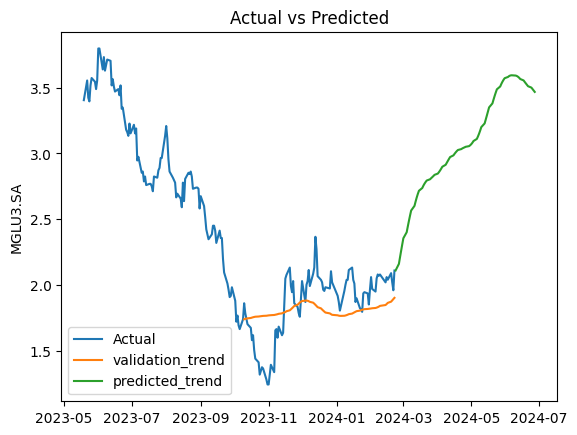

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
REDE D OR


1/1 [==============================] - 0s 41ms/step

___________________________________________________________________________
RDOR3.SA
Evaluation metric results:-
MSE is : 1.8661075555451805
MAE is : 1.0870526196640224
RMSE is : 1.3660554730848893
MAPE is : 8.80131635119493
R2 is : 0.4618245249008234

Alta estimada: 20.19 %


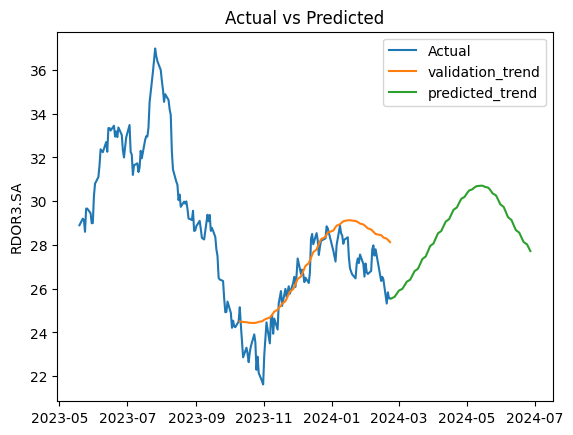

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
SANTANDER


1/1 [==============================] - 0s 43ms/step

___________________________________________________________________________
BCSA34.SA
Evaluation metric results:-
MSE is : 0.5337972469137582
MAE is : 0.6488980333014027
RMSE is : 0.7306142942166942
MAPE is : 4.299948305076763
R2 is : 0.14971979499919696

Alta estimada: 13.78 %


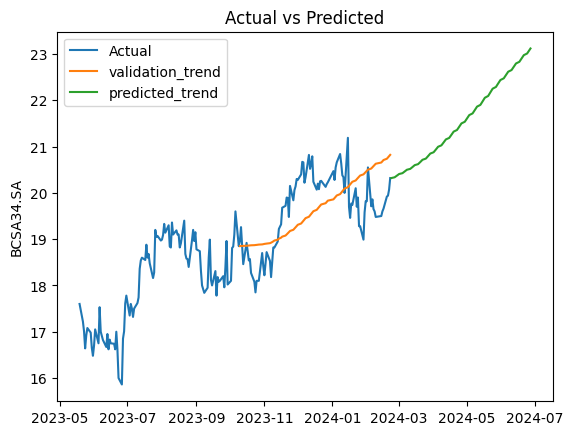

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
SONY GROUP


1/1 [==============================] - 0s 31ms/step

___________________________________________________________________________
SNEC34.SA
Evaluation metric results:-
MSE is : 507.97212458115433
MAE is : 17.798581397787412
RMSE is : 22.53823694482677
MAPE is : 4.773387395224995
R2 is : 0.2003683219027086

Alta estimada: 13.08 %


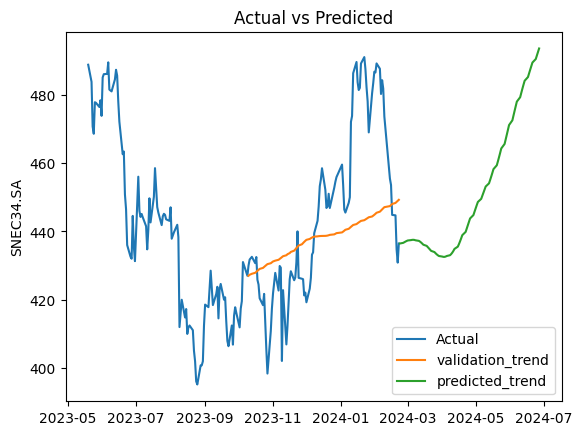

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
PALOALTO NET


1/1 [==============================] - 0s 29ms/step

___________________________________________________________________________
P2AN34.SA
Evaluation metric results:-
MSE is : 10.362839637684184
MAE is : 2.420422315676292
RMSE is : 3.219136473914112
MAPE is : 12.390752067044431
R2 is : 0.027405897423641634

Alta estimada: 12.39 %


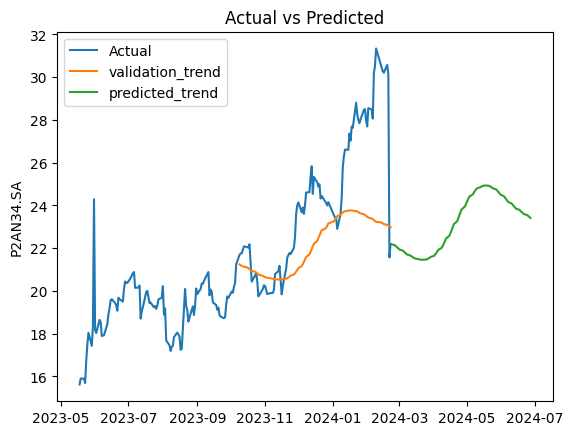

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
ZOETIS INC


1/1 [==============================] - 0s 41ms/step

___________________________________________________________________________
Z1TS34.SA
Evaluation metric results:-
MSE is : 12.729495891444301
MAE is : 2.7737792280944817
RMSE is : 3.567841909536394
MAPE is : 6.773382485562952
R2 is : 0.023637305783606344

Alta estimada: 10.65 %


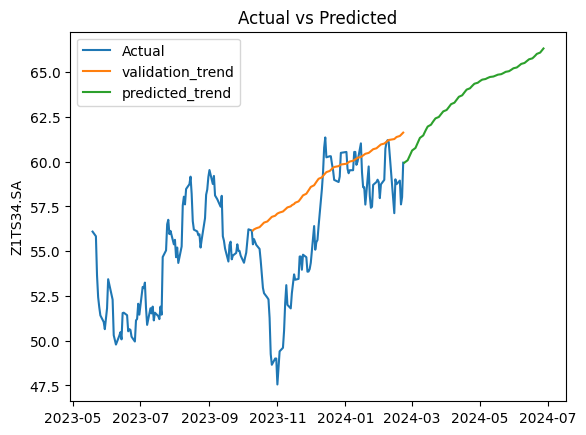

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
KRAFT HEINZ


1/1 [==============================] - 0s 42ms/step

___________________________________________________________________________
KHCB34.SA
Evaluation metric results:-
MSE is : 2.9689461551842795
MAE is : 1.3734305770195856
RMSE is : 1.7230630154420585
MAPE is : 6.013416990348199
R2 is : 0.5046011760353599

Alta estimada: 10.2 %


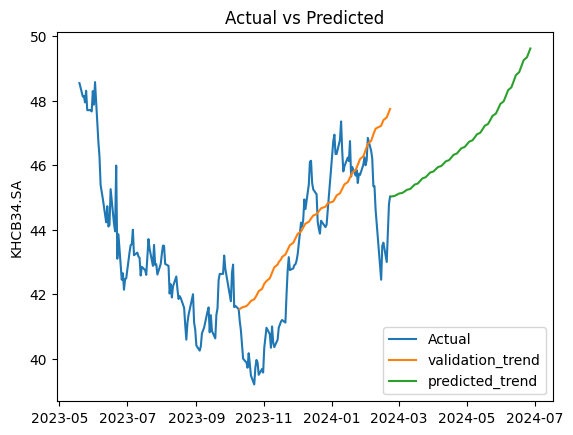

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
VIVARA S.A.


1/1 [==============================] - 0s 30ms/step

___________________________________________________________________________
VIVA3.SA
Evaluation metric results:-
MSE is : 5.751520565317821
MAE is : 1.9928291256339656
RMSE is : 2.3982328004841027
MAPE is : 10.555122143374001
R2 is : 0.4847544749122088

Alta estimada: 9.92 %


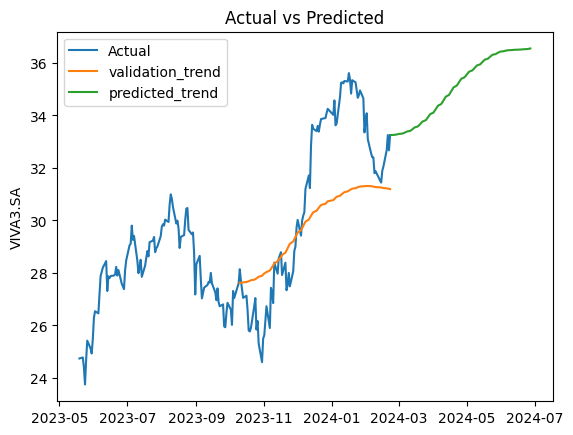

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
LLOYDS BANKI


1/1 [==============================] - 0s 31ms/step

___________________________________________________________________________
L1YG34.SA
Evaluation metric results:-
MSE is : 0.413839917695505
MAE is : 0.5031189348958461
RMSE is : 0.6433039077259713
MAPE is : 4.846348728209927
R2 is : 0.0013767205199979315

Alta estimada: 9.81 %


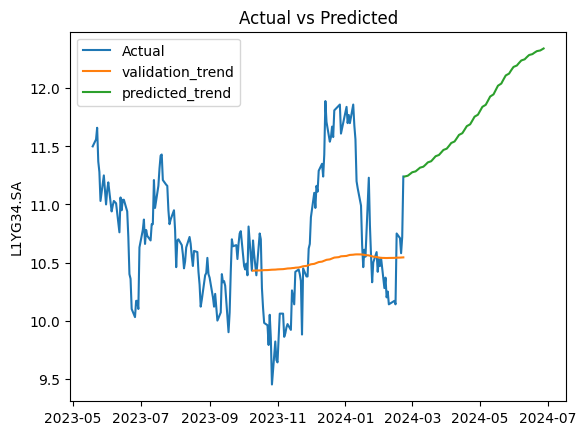

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
P.ACUCAR-CBD


1/1 [==============================] - 0s 29ms/step

___________________________________________________________________________
PCAR3.SA
Evaluation metric results:-
MSE is : 0.07213976215437513
MAE is : 0.20926445975225932
RMSE is : 0.2685884624371924
MAPE is : 8.146302596073431
R2 is : 0.3244484978062939

Alta estimada: 9.63 %


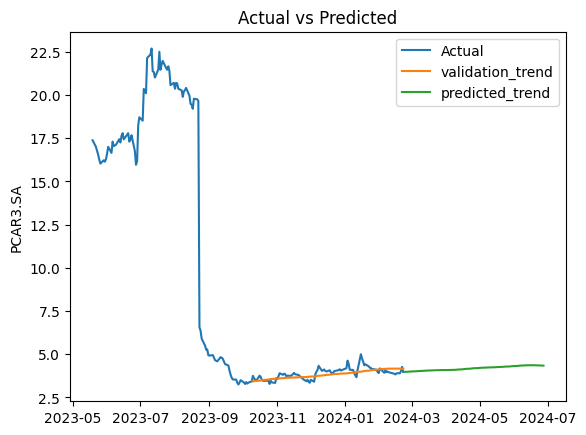

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
OUROFINO S/A


1/1 [==============================] - 0s 28ms/step

___________________________________________________________________________
OFSA3.SA
Evaluation metric results:-
MSE is : 3.445982595423764
MAE is : 1.4409217375097743
RMSE is : 1.8563357981312982
MAPE is : 7.681600900731636
R2 is : 0.1095285597807627

Alta estimada: 7.41 %


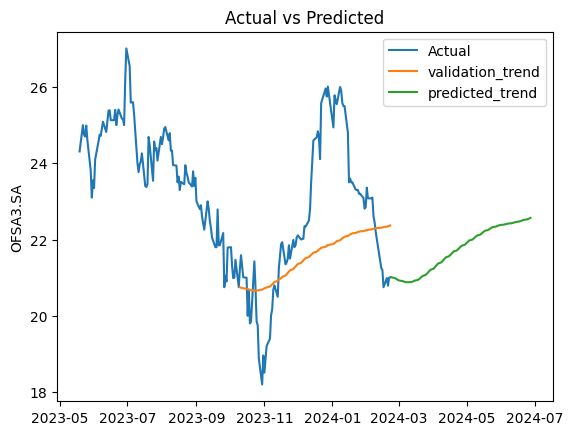

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
MONSTER BEVE


1/1 [==============================] - 0s 32ms/step

___________________________________________________________________________
M1NS34.SA
Evaluation metric results:-
MSE is : 1.5423018161452913
MAE is : 1.0460599557674277
RMSE is : 1.241894446458833
MAPE is : 5.162381042771131
R2 is : 0.10010861810356309

Alta estimada: 6.47 %


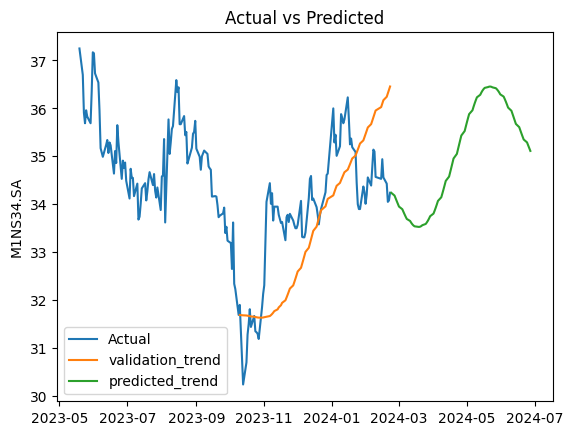

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
TEGMA


1/1 [==============================] - 0s 30ms/step

___________________________________________________________________________
TGMA3.SA
Evaluation metric results:-
MSE is : 0.841895935631984
MAE is : 0.7441423137027766
RMSE is : 0.9175488737020955
MAPE is : 4.562209324072763
R2 is : 0.3359911247877211

Alta estimada: 6.45 %


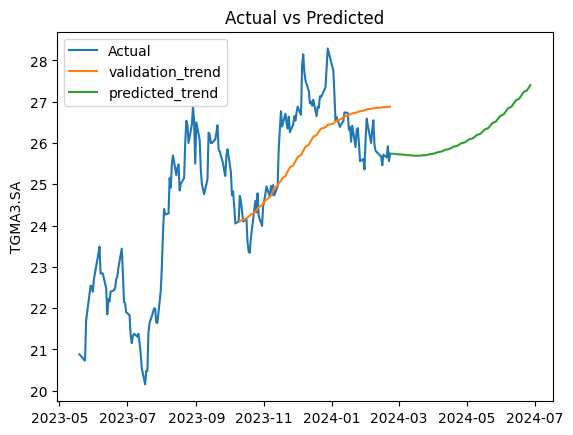

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
LILLY


1/1 [==============================] - 0s 31ms/step

___________________________________________________________________________
LILY34.SA
Evaluation metric results:-
MSE is : 77.67249782022098
MAE is : 6.253503644431213
RMSE is : 8.813200203116969
MAPE is : 6.389563586034995
R2 is : 0.17266225843747962

Alta estimada: 5.61 %


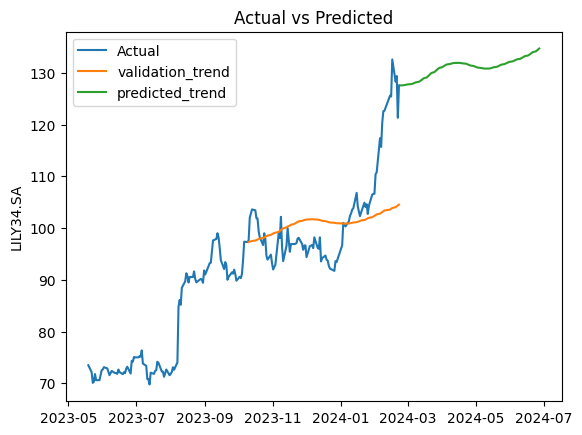

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
REALTY INCOM


1/1 [==============================] - 0s 30ms/step

___________________________________________________________________________
R1IN34.SA
Evaluation metric results:-
MSE is : 29.44224704918912
MAE is : 4.390591767971677
RMSE is : 5.426071050879183
MAPE is : 4.547809217447943
R2 is : 0.37652763748238216

Alta estimada: 5.52 %


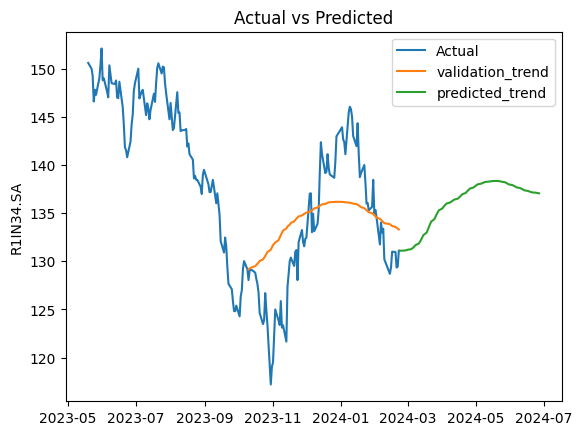

In [ ]:
for i,t in zip(sugestoes_df["Asset"],sugestoes_df["empresa"]):
  print()
  print("_"*75)
  print("_"*75)
  print(t)
  preve_acao(i+".SA",True)